**Ce script simule 5000 trajets de vélos partagés entre 100 utilisateurs et 20 stations, avec des motifs domicile-travail.**

**Il génère aléatoirement les heures de départ, les stations d’origine et de destination, ainsi que la durée des trajets.**

**Les données sont enregistrées dans un fichier CSV nommé 'simulated_bike_trips.csv' pour une analyse ultérieure.**


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# 1. Paramètres de simulation
hours = np.int64(5)
np.random.seed(42)  # Pour la reproductibilité
n_users = 100       # Nombre d'utilisateurs
n_stations = 20     # Nombre de stations
n_trips = 5000      # Nombre total de trajets
stations = [f"Station_{i}" for i in range(1, n_stations + 1)]

# 2. Simulation des utilisateurs et de leurs habitudes
user_ids = [f"User_{i}" for i in range(1, n_users + 1)]
user_home_stations = np.random.choice(stations, size=n_users)  # Station "domicile" pour chaque utilisateur
user_work_stations = np.random.choice(stations, size=n_users)  # Station "travail"

# 3. Génération des trajets
data = []
start_date = datetime(2025, 1, 1)

for _ in range(n_trips):
    user_id = np.random.choice(user_ids)
    user_index = user_ids.index(user_id)
    
    # Heure de départ : aléatoire entre 6h et 22h, avec des pics aux heures de pointe
    hour = np.random.choice(
        [6, 7, 8, 9, 16, 17, 18, 19], 
        p=[0.1, 0.2, 0.2, 0.1, 0.1, 0.2, 0.05, 0.05]
    )
    minute = np.random.randint(0, 60)
    departure_time = start_date + timedelta(days=np.random.randint(0, 30), hours=int(hour), minutes=minute)
    
    # Départ : 70% depuis domicile/travail, 30% aléatoire
    if np.random.rand() < 0.7:
        departure_station = np.random.choice([user_home_stations[user_index], user_work_stations[user_index]])
    else:
        departure_station = np.random.choice(stations)
    
    # Arrivée : dépend du départ (ex. si départ de "domicile", arrivée souvent à "travail")
    if departure_station == user_home_stations[user_index]:
        arrival_station = user_work_stations[user_index] if np.random.rand() < 0.8 else np.random.choice(stations)
    elif departure_station == user_work_stations[user_index]:
        arrival_station = user_home_stations[user_index] if np.random.rand() < 0.8 else np.random.choice(stations)
    else:
        arrival_station = np.random.choice(stations)
    
    # Durée du trajet : entre 5 et 30 minutes
    duration = np.random.randint(5, 31)
    
    data.append([user_id, departure_time, departure_station, arrival_station, duration])

# 4. Création du DataFrame
df = pd.DataFrame(data, columns=["user_id", "departure_time", "departure_station", "arrival_station", "duration_minutes"])

# 5. Sauvegarde en CSV
df.to_csv("simulated_bike_trips.csv", index=False)
print("Données simulées sauvegardées dans 'simulated_bike_trips.csv'.")
print(df.head())

Données simulées sauvegardées dans 'simulated_bike_trips.csv'.
   user_id      departure_time departure_station arrival_station  \
0  User_90 2025-01-20 09:18:00        Station_11       Station_8   
1  User_82 2025-01-28 17:10:00        Station_18      Station_10   
2   User_7 2025-01-16 16:25:00         Station_5      Station_19   
3  User_48 2025-01-05 19:04:00         Station_9       Station_9   
4  User_19 2025-01-20 17:02:00         Station_1      Station_20   

   duration_minutes  
0                11  
1                 7  
2                 5  
3                 7  
4                15  


**A. Prétraitement des données**

In [3]:
from sklearn.preprocessing import LabelEncoder

# Charger les données simulées (ou vos propres données)
df = pd.read_csv("simulated_bike_trips.csv")

# 1. Nettoyage des données
print("Nombre de trajets avant nettoyage :", len(df))

Nombre de trajets avant nettoyage : 5000


In [4]:
# Supprimer les trajets où départ = arrivée
df = df[df["departure_station"] != df["arrival_station"]]

# Supprimer les durées aberrantes (ex. < 1 minute ou > 120 minutes)
df = df[(df["duration_minutes"] >= 1) & (df["duration_minutes"] <= 120)]

# Convertir 'departure_time' en datetime
df["departure_time"] = pd.to_datetime(df["departure_time"])

# Trier par utilisateur et heure de départ
df = df.sort_values(by=["user_id", "departure_time"])

print("Nombre de trajets après nettoyage :", len(df))

Nombre de trajets après nettoyage : 4695


In [5]:
# 2. Encodage des stations
station_encoder = LabelEncoder()
stations = pd.concat([df["departure_station"], df["arrival_station"]]).unique()
station_encoder.fit(stations)

df["departure_encoded"] = station_encoder.transform(df["departure_station"])
df["arrival_encoded"] = station_encoder.transform(df["arrival_station"])

In [6]:
# 3. Création des séquences pour le LSTM
sequences = []
user_groups = df.groupby("user_id")

for user_id, group in user_groups:
    # Créer une séquence de stations visitées par l'utilisateur
    user_sequence = group["departure_encoded"].tolist() + [group["arrival_encoded"].iloc[-1]]
    sequences.append(user_sequence)

# Exemple de séquence pour le premier utilisateur
print("\nExemple de séquence pour user_id =", df["user_id"].iloc[0])
print("Stations réelles :", sequences[0])
print("Stations décodées :", station_encoder.inverse_transform(sequences[0]))


Exemple de séquence pour user_id = User_1
Stations réelles : [17, 17, 17, 17, 17, 17, 17, 17, 13, 13, 5, 13, 13, 17, 17, 17, 13, 13, 13, 15, 17, 17, 17, 13, 17, 17, 17, 13, 13, 17, 13, 13, 17, 3, 17, 17, 7, 17, 13, 8, np.int64(4)]
Stations décodées : ['Station_7' 'Station_7' 'Station_7' 'Station_7' 'Station_7' 'Station_7'
 'Station_7' 'Station_7' 'Station_3' 'Station_3' 'Station_14' 'Station_3'
 'Station_3' 'Station_7' 'Station_7' 'Station_7' 'Station_3' 'Station_3'
 'Station_3' 'Station_5' 'Station_7' 'Station_7' 'Station_7' 'Station_3'
 'Station_7' 'Station_7' 'Station_7' 'Station_3' 'Station_3' 'Station_7'
 'Station_3' 'Station_3' 'Station_7' 'Station_12' 'Station_7' 'Station_7'
 'Station_16' 'Station_7' 'Station_3' 'Station_17' 'Station_13']


In [7]:
# 4. Sauvegarde des données prétraitées
df.to_csv("preprocessed_bike_trips.csv", index=False)
print("\nDonnées prétraitées sauvegardées dans 'preprocessed_bike_trips.csv'.")


Données prétraitées sauvegardées dans 'preprocessed_bike_trips.csv'.


**B. Modélisation avec LSTM**

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [9]:
import gc

# Vider la mémoire GPU avant l'exécution
torch.mps.empty_cache()
gc.collect()
# Vérifier la disponibilité de MPS (Apple Silicon GPU)
if torch.backends.mps.is_available():
    try:
        device = torch.device("mps")
        print("Utilisation de MPS (Apple Silicon GPU)")
    except RuntimeError as e:
        print(f"Erreur avec MPS : {e}. Basculage vers le CPU.")
        device = torch.device("cpu")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Utilisation de CUDA (GPU NVIDIA)")
else:
    device = torch.device("cpu")
    print("Utilisation du CPU")

print(f"Périphérique utilisé : {device}")

Utilisation de MPS (Apple Silicon GPU)
Périphérique utilisé : mps


In [10]:
# 1. Charger les données prétraitées
df = pd.read_csv("preprocessed_bike_trips.csv")

In [11]:
# 2. Préparation des séquences pour PyTorch
def create_sequences(data, seq_length=3):
    sequences = []
    user_groups = data.groupby("user_id")
    
    for _, group in user_groups:
        stations = group["departure_encoded"].tolist() + [group["arrival_encoded"].iloc[-1]]
        for i in range(len(stations) - seq_length):
            sequences.append({
                "input": stations[i:i+seq_length],
                "target": stations[i+seq_length]
            })
    return sequences

seq_length = 3  # Longueur des séquences d'entrée
sequences = create_sequences(df, seq_length)

In [12]:
# 3. Split train/test
train_data, test_data = train_test_split(sequences, test_size=0.2, random_state=42)

In [13]:
# 4. Classe Dataset pour PyTorch
class StationDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        return (
            torch.tensor(sequence["input"], dtype=torch.long),
            torch.tensor(sequence["target"], dtype=torch.long)
        )

train_dataset = StationDataset(train_data)
test_dataset = StationDataset(test_data)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [14]:
# 5. Architecture LSTM
class LSTMModel(nn.Module):
    def __init__(self, num_stations, embedding_dim=64, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(num_stations, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, dropout=0.3, batch_first=True)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_stations)

        
    def forward(self, x):
        x = self.embedding(x)  # (batch, seq_len) -> (batch, seq_len, embedding_dim)
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim)
        out = self.batchnorm(lstm_out[:, -1, :])  # BatchNorm sur la dernière sortie
        return out

num_stations = len(station_encoder.classes_)
model = LSTMModel(num_stations)

/Users/charlyrenard/Documents/M2/Projet_IA/arret_veloPredict/my_env/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [15]:
# 6. Entraînement
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
accuracies = []

epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    test_loss = 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_losses.append(test_loss / len(test_loader))
    accuracy = accuracy_score(all_targets, all_preds)
    accuracies.append(accuracy)
    
    # Métriques
    accuracy = accuracy_score(all_targets, all_preds)
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss/len(train_loader):.4f} | "
          f"Test Loss: {test_loss/len(test_loader):.4f} | "
          f"Accuracy: {accuracy:.4f}")
    
    torch.save(model.state_dict(), "lstm_station_prediction.pth")

Epoch 1/10 | Train Loss: 3.7554 | Test Loss: 3.2795 | Accuracy: 0.2848
Epoch 2/10 | Train Loss: 3.1681 | Test Loss: 3.0471 | Accuracy: 0.2825
Epoch 3/10 | Train Loss: 2.9727 | Test Loss: 2.9382 | Accuracy: 0.3026
Epoch 4/10 | Train Loss: 2.8497 | Test Loss: 2.8685 | Accuracy: 0.2937
Epoch 5/10 | Train Loss: 2.7514 | Test Loss: 2.8204 | Accuracy: 0.3026
Epoch 6/10 | Train Loss: 2.6690 | Test Loss: 2.7649 | Accuracy: 0.3070
Epoch 7/10 | Train Loss: 2.6068 | Test Loss: 2.7284 | Accuracy: 0.3059
Epoch 8/10 | Train Loss: 2.5334 | Test Loss: 2.7128 | Accuracy: 0.3014
Epoch 9/10 | Train Loss: 2.4775 | Test Loss: 2.6804 | Accuracy: 0.2948
Epoch 10/10 | Train Loss: 2.4441 | Test Loss: 2.6800 | Accuracy: 0.3037


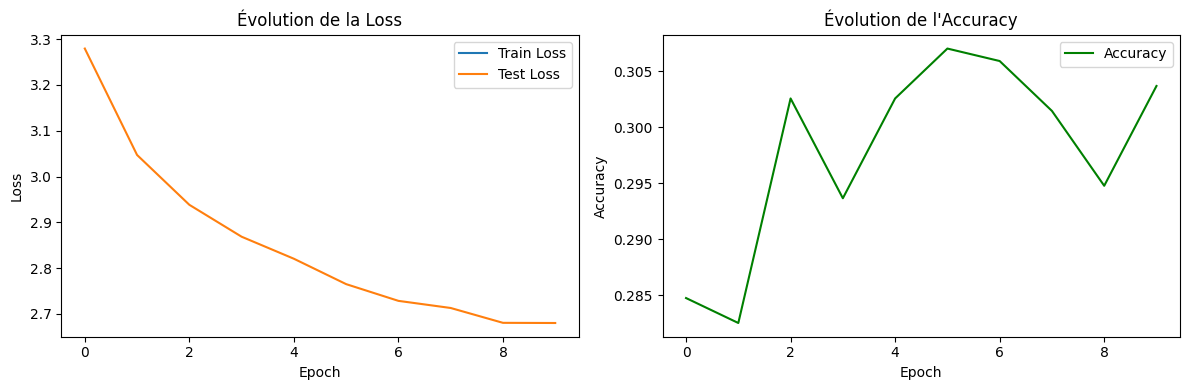

In [16]:
import matplotlib.pyplot as plt

# 7. Tracé des courbes
plt.figure(figsize=(12, 4))

# Courbe de Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Évolution de la Loss")
plt.legend()

# Courbe d'Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label="Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Évolution de l'Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

**C. Comparaison avec d’autres méthodes**

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from collections import defaultdict

# 1. Charger les données prétraitées
df = pd.read_csv("preprocessed_bike_trips.csv")

# 2. Préparation des données (identique à la partie LSTM)
def create_sequences(data, seq_length=3):
    sequences = []
    user_groups = data.groupby("user_id")
    for _, group in user_groups:
        stations = group["departure_encoded"].tolist() + [group["arrival_encoded"].iloc[-1]]
        for i in range(len(stations) - seq_length):
            sequences.append({
                "input": stations[i:i+seq_length],
                "target": stations[i+seq_length]
            })
    return sequences

sequences = create_sequences(df, seq_length=3)
X = np.array([seq["input"] for seq in sequences])
y = np.array([seq["target"] for seq in sequences])

# Split train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# 3. Méthode 1: Trip Chaining (heuristique)
def trip_chaining_predict(X_test, user_home_stations):
    y_pred = []
    for seq in X_test:
        last_station = seq[-1]
        # Règle simple : Si l'utilisateur est à "domicile", prédire "travail" et inversement
        if last_station == user_home_stations.get(seq[0], -1):  # seq[0] = user_id encoded
            y_pred.append(user_work_stations.get(seq[0], last_station))
        else:
            y_pred.append(user_home_stations.get(seq[0], last_station))
    return np.array(y_pred)

# Dictionnaires fictifs (à remplacer par vos données réelles)
user_home_stations = {user_id: home_station for user_id, home_station in zip(df["user_id"].unique(), df.groupby("user_id")["departure_encoded"].first())}
user_work_stations = {user_id: work_station for user_id, work_station in zip(df["user_id"].unique(), df.groupby("user_id")["arrival_encoded"].first())}

y_pred_tc = trip_chaining_predict(X_test, user_home_stations)
accuracy_tc = accuracy_score(y_test, y_pred_tc)
print(f"Accuracy Trip Chaining: {accuracy_tc:.4f}")

Accuracy Trip Chaining: 0.2670


In [19]:
# 4. Méthode 2: Random Forest (baseline)
# Aplatir les séquences pour Random Forest
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_flat, y_train)
y_pred_rf = rf.predict(X_test_flat)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy Random Forest: {accuracy_rf:.4f}")

Accuracy Random Forest: 0.2347


In [21]:
# 5. Comparaison avec le LSTM (supposons que vous avez déjà un modèle entraîné)
# Exemple avec un modèle LSTM fictif (à remplacer par votre vrai modèle)
class LSTMModel(nn.Module):
    def __init__(self, num_stations, embedding_dim=64, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(num_stations, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, dropout=0.3, batch_first=True)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_stations)

        
    def forward(self, x):
        x = self.embedding(x)  # (batch, seq_len) -> (batch, seq_len, embedding_dim)
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_dim)
        out = self.batchnorm(lstm_out[:, -1, :])  # BatchNorm sur la dernière sortie
        return out
    pass

# Charger le modèle et prédire
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model_lstm = LSTMModel(num_stations=len(station_encoder.classes_)).to(device)
model_lstm.load_state_dict(torch.load("lstm_station_prediction.pth", map_location=device))
model_lstm.eval()

# Préparer les données
X_test_tensor = torch.tensor(X_test, dtype=torch.long).to(device)

# Prédiction
with torch.no_grad():
    outputs = model_lstm(X_test_tensor)
    y_pred_lstm = torch.argmax(outputs, dim=1).cpu().numpy()

# Calcul de l'accuracy
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
print(f"Accuracy LSTM: {accuracy_lstm:.4f}")

Accuracy LSTM: 0.3037


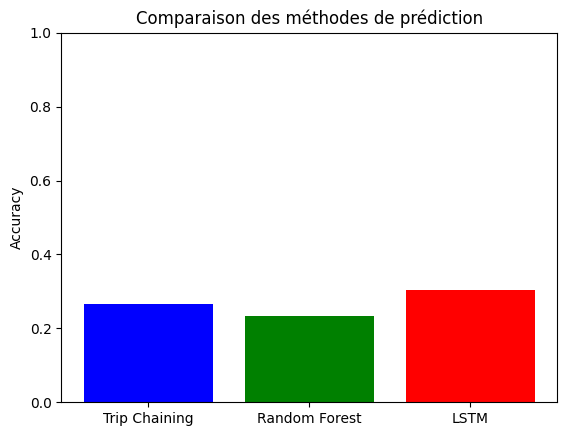

In [22]:
# 6. Visualisation des résultats
import matplotlib.pyplot as plt

methods = ["Trip Chaining", "Random Forest", "LSTM"]
accuracies = [accuracy_tc, accuracy_rf, accuracy_lstm]

plt.bar(methods, accuracies, color=["blue", "green", "red"])
plt.ylabel("Accuracy")
plt.title("Comparaison des méthodes de prédiction")
plt.ylim(0, 1)
plt.show()

**D. Matrice Origine-Destination (OD)**

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Charger les données et prédictions
df = pd.read_csv("preprocessed_bike_trips.csv")
station_names = station_encoder.classes_  # Récupérer les noms des stations depuis le LabelEncoder

# 2. Matrice OD Réelle (si les vraies destinations sont disponibles)
real_od = pd.crosstab(df["departure_station"], df["arrival_station"])
print("Matrice OD Réelle :\n", real_od.head())

Matrice OD Réelle :
 arrival_station    Station_1  Station_10  Station_11  Station_12  Station_13  \
departure_station                                                              
Station_1                  0           6           7          19           5   
Station_10                 4           0          15          22           6   
Station_11                 3          13           0           6           3   
Station_12                18          24           4           0          24   
Station_13                 4           4           6          20           0   

arrival_station    Station_14  Station_15  Station_16  Station_17  Station_18  \
departure_station                                                               
Station_1                   4          19           5          12           3   
Station_10                  1           6           4           3           6   
Station_11                 20          25           8           5           3   
Station_12   

In [24]:
# 3. Matrice OD Prédite (à partir du LSTM)
# Supposons que y_pred_lstm contient les prédictions du modèle (ex. [station3, station1, ...])
predicted_stations = station_encoder.inverse_transform(y_pred_lstm)  # Décoder les prédictions
df_test = pd.DataFrame({
    "departure_station": [station_names[x[0]] for x in X_test],  # 1ère station de la séquence
    "arrival_station_pred": predicted_stations
})

predicted_od = pd.crosstab(df_test["departure_station"], df_test["arrival_station_pred"])
print("\nMatrice OD Prédite :\n", predicted_od.head())


Matrice OD Prédite :
 arrival_station_pred  Station_1  Station_10  Station_11  Station_12  \
departure_station                                                     
Station_1                    30           0           0           4   
Station_10                    1          28           2           2   
Station_11                    0           0          22           0   
Station_12                    3           0           0          29   
Station_13                    1           0           0           0   

arrival_station_pred  Station_13  Station_14  Station_15  Station_16  \
departure_station                                                      
Station_1                      1           0           2           0   
Station_10                     0           0           4           0   
Station_11                     0           1           3           0   
Station_12                     1           0           9           0   
Station_13                    12           3   

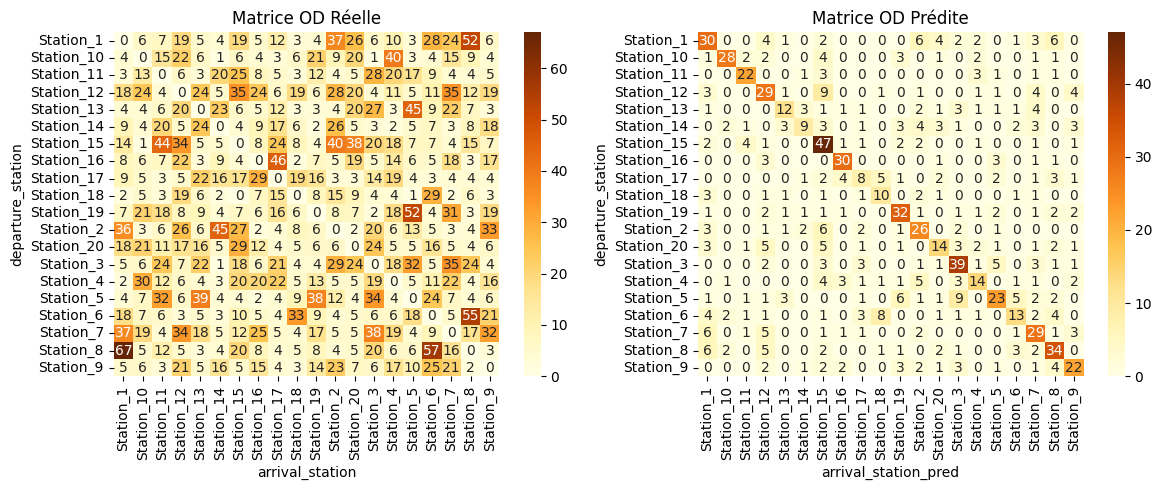

In [25]:
# 4. Comparaison des matrices (si réel disponible)
if not real_od.empty:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(real_od, cmap="YlOrBr", annot=True, fmt="d")
    plt.title("Matrice OD Réelle")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(predicted_od, cmap="YlOrBr", annot=True, fmt="d")
    plt.title("Matrice OD Prédite")
    
    plt.tight_layout()
    plt.show()

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

def plot_sankey(od_matrix, title="Flux entre stations"):
    stations = list(od_matrix.index)
    sources, targets, values = [], [], []
    for i, origin in enumerate(stations):
        for j, destination in enumerate(stations):
            val = od_matrix.loc[origin, destination]
            if val > 0:
                sources.append(i)
                targets.append(j)
                values.append(val)

    fig = go.Figure(go.Sankey(
        node=dict(label=stations, pad=15),
        link=dict(source=sources, target=targets, value=values)
    ))
    fig.update_layout(title_text=title, font_size=10)
    fig.write_html("sankey_plot.html", auto_open=True)

def plot_heatmap(od_matrix, title="Flux OD"):
    fig = px.imshow(od_matrix,
                    labels=dict(x="Arrivée", y="Départ", color="Flux"),
                    x=od_matrix.columns,
                    y=od_matrix.index,
                    color_continuous_scale='YlOrRd')
    fig.update_layout(title=title)
    fig.write_html("heatmap_plot.html", auto_open=True)



In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap_static(od_matrix, title="Flux OD"):
    plt.figure(figsize=(10, 8))
    sns.heatmap(od_matrix, annot=True, fmt=".0f", cmap="YlOrRd")
    plt.title(title)
    plt.xlabel("Arrivée")
    plt.ylabel("Départ")
    plt.tight_layout()
    plt.show()


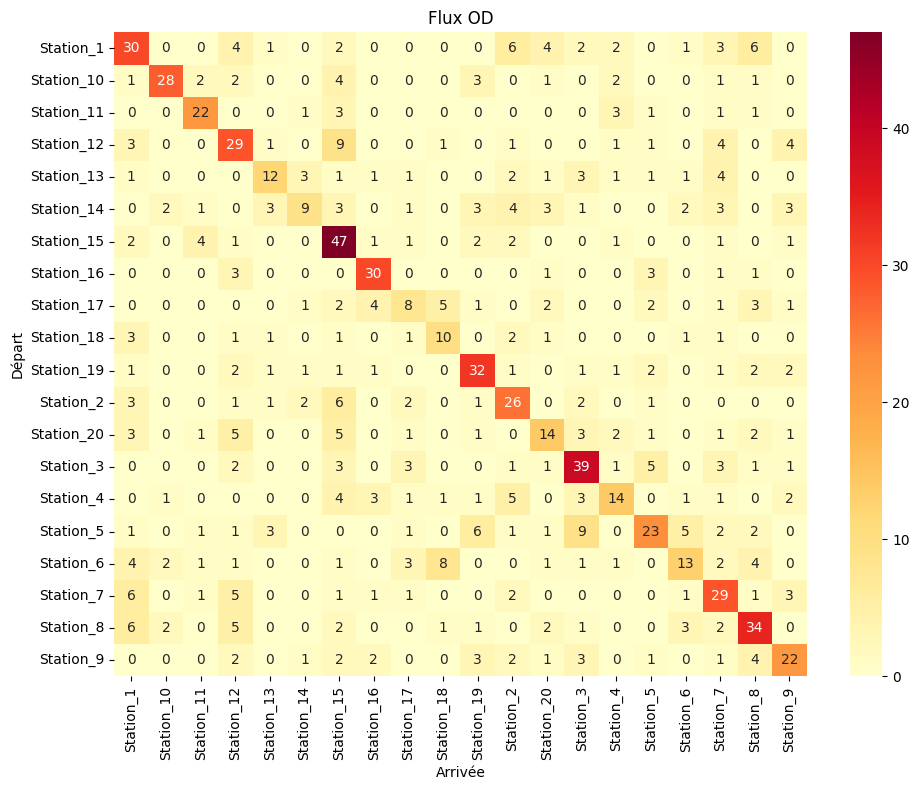

In [50]:
plot_heatmap_static(predicted_od)

In [52]:
plot_heatmap(predicted_od)
plot_sankey(predicted_od)